In [1]:
# ALASKA AND HAWAII: https://medium.com/@alex_44314/use-python-geopandas-to-make-a-us-map-with-alaska-and-hawaii-39a9f5c222c6 

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from urllib.request import Request, urlopen
from shapely.geometry import Point
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML
import gc

%matplotlib inline
# activate plot theme
import qeds
# qeds.themes.mpl_style();
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 100

## Maps

### Court Shopping Among Inhouse Attorneys

In [4]:
# import the inhouse attorneys dataset
df_inhouse = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/inhouse_attorneys.csv")

# drop rows without zip codes
print(len(df_inhouse.index))
df_inhouse.dropna(subset=["zip"], how="all", inplace=True)
print(len(df_inhouse.index))

# import court district and zip code shape files
district_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/U.S._District_Courts.zip")
zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2020_us_zcta510.zip")

1046
1041


In [5]:
# merge the inhouse attorney dataset with the zip code file
zip_df["ZCTA5CE10"] = zip_df["ZCTA5CE10"].astype(float)
inhouse_zip = df_inhouse.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE10")
inhouse_zip[inhouse_zip.isna().any(axis=1)]

# inhouse_zip[["zip","ZCTA5CE20"]].head(20)
inhouse_zip.head()

inhouse_zip[inhouse_zip["ZCTA5CE10"].isna()]
inhouse_zip.drop(columns=["CLASSFP10", "MTFCC10", "FUNCSTAT10",	"ALAND10",	"AWATER10",	"INTPTLAT10", "INTPTLON10"], inplace=True)

# merge zip codes not included in 2010 zip code file with 2022 zip code file
missing = inhouse_zip[inhouse_zip["ZCTA5CE10"].isna()].iloc[:, :]
missing.drop(columns=['ZCTA5CE10', 'geometry'], inplace=True)

zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2022_us_zcta520.zip")

zip_df["ZCTA5CE20"] = zip_df["ZCTA5CE20"].astype(float)
missing = missing.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE20")
# missing[["zip"]][missing["ZCTA5CE20"].isna()].sort_values("zip")

# merge missing values back to the full dataset
missing.drop(columns=["GEOID10", 'GEOID20',
 'CLASSFP20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20'], inplace=True)
missing = missing.rename(columns={"ZCTA5CE20": "ZCTA5CE10"})

inhouse_zip = inhouse_zip[inhouse_zip["ZCTA5CE10"].isna() == False]
inhouse_zip = pd.concat([inhouse_zip, missing], axis=0)

,name_attorney,party_row_count,case_row_id,case_number,party_type_x,attorney_row_count,contactinfo,position,zip,firm,first_name,gender,defendant,plaintiff,other,defendant.1,defendant_F,plaintiff_M,plaintiff_F,other_M,other_F,male,female,case_name,court_name,year_filed,case_order,courthouse,court_region,court_state,patent_infringement,tot_def,tot_plain,tot_other,tot_def_M,tot_def_F,tot_plain_M,tot_plain_F,tot_other_M,tot_other_F,tot_M,tot_F,tot,number_docs,party_type_y,name_row_count,name,ZCTA5CE10,GEOID10,CLASSFP10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
0,A. William Urquhart,41124,8820,1:00-cv-12234-EFH,plaintiff,96687,"Quinn Emanuel Urquhart Oliver & Hedges, LLP; 5...",LEAD ATTORNEY; PRO HAC VICE; ATTORNEY TO BE NO...,10010.0,"Quinn Emanuel Urquhart Oliver & Hedges, Llp",a.,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"Freedom Wireless Inc v. Boston Communication, ...",District Of Massachusetts (Boston),2000.0,12234.0,1,NaN,Massachusetts,1.0,76.0,21.0,2.0,59.0,17.0,15.0,6.0,2.0,0.0,76.0,23.0,99.0,154.0,Interested Party,50888,"Quinn Emanuel Urquhart Oliver & Hedges, Llp",10010.0,10010,B5,G6350,S,988479.0,0.0,+40.7391043,-073.9824552,"POLYGON ((-73.99374 40.74162, -73.99329 40.742..."
1,"ANTHONY BAIAMONTE , III",319447,56914,3:12-cv-06053-MAS-TJB,defendant,892291,"MEDICAL DIAGNOSTIC LABORATORIES, LLC; 2439 KUS...",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,8690.0,Medical Diagnostic Laboratories,anthony,M,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,GENETIC TECHNOLOGIES LIMITED v. MEDICAL DIAGNO...,District Of New Jersey [Live] (Trenton),2012.0,6053.0,3,NaN,New Jersey,1.0,2.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,4.0,0.0,4.0,74.0,Defendant,417893,Medical Diagnostic Laboratories,8690.0,08690,B5,G6350,S,18147603.0,276385.0,+40.2245049,-074.6602794,"MULTIPOLYGON (((-74.63848 40.24492, -74.63598 ..."
2,Aaron Keyt,168140,32050,2:01-cv-00985-MJP,plaintiff,451267,"DIGITAL CONTROL INC; 425 SW 41ST ST; RENTON, W...",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,98055.0,Digital Control Inc,aaron,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Digital Control Inc v. McLaughlin Mfg Co,United States District Court For The Western D...,2001.0,985.0,2,Western,Washington,1.0,4.0,3.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,7.0,0.0,7.0,342.0,Plaintiff,209208,Digital Control Inc,98055.0,98055,B5,G6350,S,12410305.0,213366.0,+47.4474725,-122.2003559,"POLYGON ((-122.22025 47.4303, -122.22022 47.43..."
3,Aaron Keyt,172368,32824,2:02-cv-02085-MJP,plaintiff,461784,"DIGITAL CONTROL INC; 425 SW 41ST ST; RENTON, W...",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,98055.0,Digital Control Inc,aaron,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,Digital Control Inc v. McLaughlin Mfg Co,United States District Court For The Western D...,2002.0,2085.0,2,Western,Washington,1.0,2.0,3.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,5.0,12.0,Plaintiff,214987,Digital Control Inc,98055.0,98055,B5,G6350,S,12410305.0,213366.0,+47.4474725,-122.2003559,"POLYGON ((-122.22025 47.4303, -122.22022 47.43..."
4,Aaron Keyt,174413,33223,2:03-cv-00103-MJP,plaintiff,466698,"DIGITAL CONTROL INC; 425 SW 41ST ST; RENTON, W...",LEAD ATTORNEY; ATTORNEY TO BE NOTICED,98055.0,Digital Control Inc,aaron,M,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,"Digital Control Inc, et al v. Charles Machine ...",United States District Court For The Western D...,2003.0,103.0,2,Western,Washington,1.0,7.0,7.0,0.0,6.0,1.0,7.0,0.0,0.0,0.0,13.0,1.0,14.0,374.0,Plaintiff,217624,Digital Control Inc,98055.0,98055,B5,G6350,S,12410305.0,213366.0,+47.4474725,-122.2003559,"POLYGON ((-122.22025 47.4303, -122.22022 47.43..."


In [8]:
# convert the inhouse_zip dataframe to a geodataframe
inhouse_zip = gpd.GeoDataFrame(inhouse_zip, geometry="geometry")

# use to_crs to ensure that the units for the polygons are the same
district_df.to_crs(crs=4326, inplace=True)
inhouse_zip.to_crs(crs=4326, inplace=True)

# merge the dataframes
inhouse_zip = gpd.sjoin(inhouse_zip, district_df, how="left", predicate="intersects")

# extract court region associated with each zip
for region in ["Eastern", "Southern", "Western", "Northern"]:
    inhouse_zip.loc[inhouse_zip.NAME.str.contains(region, na=False), "zip_region"] = region

# alter formatting of str to match
inhouse_zip["zip_region"] = inhouse_zip["zip_region"].str.strip()
inhouse_zip["STATE_NAME"] = inhouse_zip["STATE_NAME"].str.strip()
inhouse_zip["zip_region"] = inhouse_zip["zip_region"].fillna("None")
inhouse_zip["court_region"] = inhouse_zip["court_region"].fillna("None")

# check if district where the attorney is located is the same as the district where they filed
inhouse_zip["correct_region"] = np.where(inhouse_zip['zip_region'] == inhouse_zip['court_region'], 1, 0)
inhouse_zip["correct_state"] = np.where(inhouse_zip['STATE_NAME'] == inhouse_zip['court_state'], 1, 0)
inhouse_zip["court_shopping"] = np.where(inhouse_zip['correct_region'] + inhouse_zip['correct_state'] == 2, 0, 1)

# inhouse_zip[["zip_region", "court_region", "STATE_NAME", "court_state", "correct_region", "correct_state", "court_shopping"]].head(100)

In [77]:
# create new df with only plaintiff attorneys
df_p = inhouse_zip.dropna(subset=["gender", "court_shopping"])
df_p = df_p[df_p["plaintiff"] == 1]

# create variables indicating female and male court shopping
df_p["court_shop_F"] = df_p["court_shopping"] * df_p["female"]
df_p["court_shop_M"] = df_p["court_shopping"] * df_p["male"]

# aggregate across district
df_p_map = df_p[["NAME", "plaintiff", "male", "female", "court_shopping", "court_shop_M", "court_shop_F"]]
df_p_map = df_p_map.groupby("NAME").agg("sum")
df_p_map = df_p_map.reset_index()

# merge w district data
df_p_map = district_df.merge(df_p_map, on="NAME", how="left")
df_p_map = df_p_map.fillna(0)

df_p_map.set_geometry("geometry", inplace=True)

In [95]:
df_p_map.sort_values("court_shopping", ascending=False).head()

,OBJECTID,NAME,STATE_ABBR,STATE_FIPS,STATE_NAME,Website,Circuit,Court_Webs,Population,geometry,plaintiff,male,female,court_shopping,court_shop_M,court_shop_F
10,11,California Central District Court,CA,06,California,https://pacer.uscourts.gov/file-case/court-cme...,09,https://www.cacd.uscourts.gov/,19375333,"MULTIPOLYGON (((-118.59513 33.03596, -118.5947...",49.0,25.0,24.0,47.0,25.0,22.0
7,8,California Northern District Court,CA,06,California,https://pacer.uscourts.gov/file-case/court-cme...,09,https://www.cand.uscourts.gov/,8410224,"MULTIPOLYGON (((-121.46546 35.88766, -121.4656...",41.0,28.0,13.0,20.0,13.0,7.0
38,39,Massachusetts District Court,MA,25,Massachusetts,https://pacer.uscourts.gov/file-case/court-cme...,01,https://www.mad.uscourts.gov/,7029917,"MULTIPOLYGON (((-70.81095 41.26189, -70.81062 ...",24.0,19.0,5.0,14.0,12.0,2.0
19,20,Georgia Northern District Court,GA,13,Georgia,https://pacer.uscourts.gov/file-case/court-cme...,11,https://www.gand.uscourts.gov/,7044573,"POLYGON ((-84.29867 32.99968, -84.29868 33.004...",21.0,13.0,8.0,12.0,6.0,6.0
77,78,Texas Northern District Court,TX,48,Texas,https://pacer.uscourts.gov/file-case/court-cme...,05,https://www.txnd.uscourts.gov/,7485789,"POLYGON ((-102.245 36.50071, -102.22059 36.500...",15.0,13.0,2.0,11.0,11.0,0.0
24,25,Illinois Northern District Court,IL,17,Illinois,https://pacer.uscourts.gov/file-case/court-cme...,07,https://www.ilnd.uscourts.gov/Default.aspx,9403135,"MULTIPOLYGON (((-87.65549 41.91008, -87.6554 4...",53.0,46.0,7.0,9.0,6.0,3.0
11,12,Colorado District Court,CO,08,Colorado,https://pacer.uscourts.gov/file-case/court-cme...,10,http://www.cod.uscourts.gov/Home.aspx,5773714,"POLYGON ((-106.87561 41.003, -106.85778 41.002...",15.0,9.0,6.0,7.0,7.0,0.0
74,75,Texas Southern District Court,TX,48,Texas,https://pacer.uscourts.gov/file-case/court-cme...,05,https://www.txs.uscourts.gov/,9960450,"MULTIPOLYGON (((-97.22012 25.99741, -97.22027 ...",7.0,7.0,0.0,6.0,6.0,0.0
83,84,Washington Western District Court,WA,53,Washington,https://pacer.uscourts.gov/file-case/court-cme...,09,https://www.wawd.uscourts.gov/,6037688,"MULTIPOLYGON (((-122.28916 45.55549, -122.2884...",18.0,16.0,2.0,6.0,4.0,2.0
51,52,New York Southern District Court,NY,36,New York,https://pacer.uscourts.gov/file-case/court-cme...,02,https://www.nysd.uscourts.gov/,5383204,"MULTIPOLYGON (((-74.00838 40.6864, -74.00832 4...",11.0,9.0,2.0,5.0,5.0,0.0


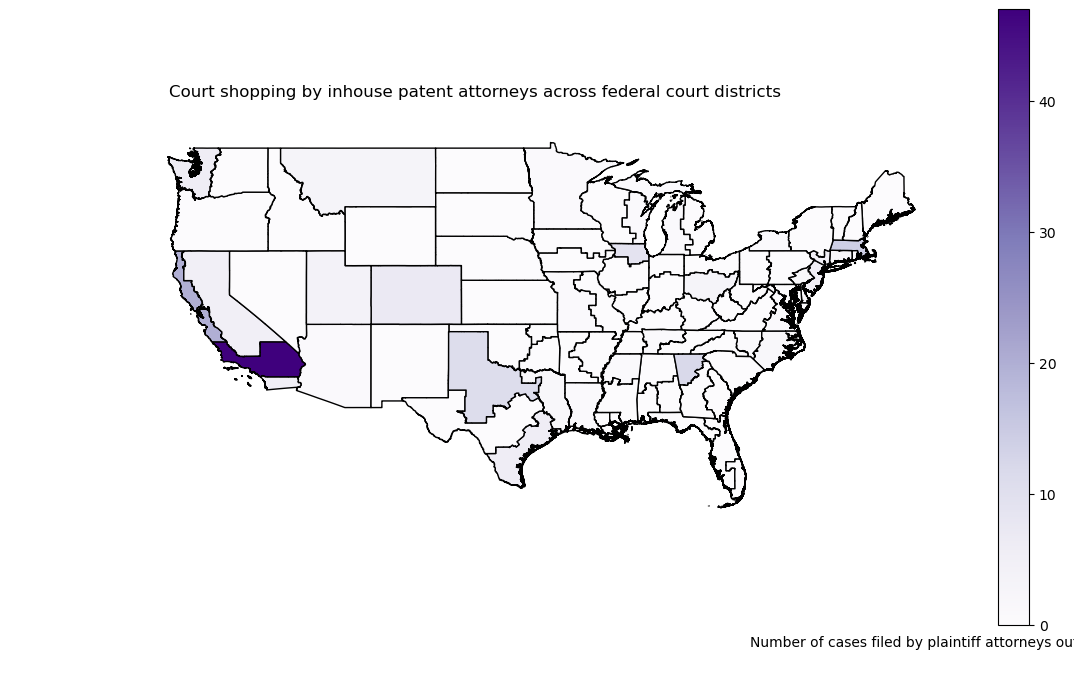

In [99]:
fig, gax = plt.subplots(figsize=(15,8))

df_p_map.plot(ax=gax, edgecolor="black", column="court_shopping", legend=True, vmin=0, vmax=47, cmap="Purples")
# zip_df_merge.plot(
   # ax=gax, edgecolor="none", column='female', legend=True, vmin=0, vmax=30, cmap="RdPu" #range of your column value for the color legend
# )

# Add text to let people know what we are plotting
gax.annotate("Number of cases filed by plaintiff attorneys outside of their jurisdiction",xy=(0.4, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

gax.set_xlim(-137, -65)
gax.set_ylim(23, 52) 

gax.set_title("Court shopping by inhouse patent attorneys across federal court districts")

plt.axis('off')

plt.show()

### Attorneys involved in districts outside location

In [3]:
district_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/U.S._District_Courts.zip")

In [5]:
df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")
zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2020_us_zcta510.zip")

# drop rows without zip codes
print(len(df_att.index))
df_att.dropna(subset=["zip"], how="all", inplace=True)
df_att["zip"] = df_att["zip"]
print(len(df_att.index))

zip_df["ZCTA5CE10"] = zip_df["ZCTA5CE10"].astype(float)

C:\Users\schwa\AppData\Local\Temp\ipykernel_14448\3787966836.py:1: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  df_att = pd.read_csv("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/attorneys_merged.csv")


425976
401827


In [6]:
# merge the attorney dataset with the zip code file
att_zip = df_att.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE10")
att_zip[att_zip.isna().any(axis=1)]

att_zip.drop(columns=["CLASSFP10", "MTFCC10", "FUNCSTAT10",	"ALAND10",	"AWATER10",	"INTPTLAT10", "INTPTLON10"], inplace=True)

# merge zip codes not included in 2010 zip code file with 2022 zip code file
missing = att_zip[att_zip["ZCTA5CE10"].isna()].iloc[:, :]
missing.drop(columns=['ZCTA5CE10', 'geometry'], inplace=True)

zip_df = gpd.read_file("C://Users/schwa/OneDrive/Desktop/School/ECO225/Data/tl_2022_us_zcta520.zip")

zip_df["ZCTA5CE20"] = zip_df["ZCTA5CE20"].astype(float)
missing = missing.merge(zip_df, how="left", left_on="zip", right_on="ZCTA5CE20")
# missing[["zip"]][missing["ZCTA5CE20"].isna()].sort_values("zip")

# merge missing values back to the full dataset
missing.drop(columns=["GEOID10", 'GEOID20',
 'CLASSFP20',
 'MTFCC20',
 'FUNCSTAT20',
 'ALAND20',
 'AWATER20',
 'INTPTLAT20',
 'INTPTLON20'], inplace=True)
missing = missing.rename(columns={"ZCTA5CE20": "ZCTA5CE10"})

att_zip = att_zip[att_zip["ZCTA5CE10"].isna() == False]
att_zip = pd.concat([att_zip, missing], axis=0)

In [7]:
list(att_zip)

['case_row_id',
 'name_attorney',
 'case_number',
 'party_row_count',
 'party_type',
 'attorney_row_count',
 'contactinfo',
 'position',
 'zip',
 'firm',
 'first_name',
 'gender',
 'defendant',
 'plaintiff',
 'other',
 'defendant_M',
 'defendant_F',
 'plaintiff_M',
 'plaintiff_F',
 'other_M',
 'other_F',
 'male',
 'female',
 'case_name',
 'court_name',
 'year_filed',
 'case_order',
 'courthouse',
 'court_region',
 'court_state',
 'patent_infringement',
 'tot_def',
 'tot_plain',
 'tot_other',
 'tot_def_M',
 'tot_def_F',
 'tot_plain_M',
 'tot_plain_F',
 'tot_other_M',
 'tot_other_F',
 'tot_M',
 'tot_F',
 'tot',
 'number_docs',
 'ZCTA5CE10',
 'GEOID10',
 'geometry']

In [7]:
df_a = att_zip[att_zip["ZCTA5CE10"].isna() == False]
df_a = att_zip[['case_row_id', "zip", 'defendant',
 'plaintiff',
 'other',
 'defendant_M',
 'defendant_F',
 'plaintiff_M',
 'plaintiff_F',
 'male',
 'female','court_region',
 'court_state',
 'patent_infringement',
 'tot_def',
 'tot_plain',
 'tot_def_M',
 'tot_def_F',
 'tot_plain_M',
 'tot_plain_F',
 'tot_M',
 'tot_F',
 'tot',
 'number_docs', "geometry"]]

del [att_zip, zip_df, missing, df_att]
gc.collect()
att_zip = pd.DataFrame()
zip_df = pd.DataFrame()
missing = pd.DataFrame()
df_att = pd.DataFrame()

In [13]:
# convert the att_zip dataframe to a geodataframe
df_a = gpd.GeoDataFrame(df_a, geometry="geometry", crs=4326)

# use to_crs to ensure that the units for the polygons are the same
district_df.to_crs(crs=4326, inplace=True)

In [ ]:
# merge the dataframes
df_a = gpd.sjoin(df_a, district_df, how="left", predicate="intersects")

In [ ]:
# extract court region associated with each zip
for region in ["Eastern", "Southern", "Western", "Northern"]:
    df_a.loc[df_a.NAME.str.contains(region, na=False), "zip_region"] = region

# alter formatting of str to match
df_a["zip_region"] = df_a["zip_region"].str.strip()
df_a["STATE_NAME"] = df_a["STATE_NAME"].str.strip()
df_a["zip_region"] = df_a["zip_region"].fillna("None")
df_a["court_region"] = df_a["court_region"].fillna("None")

In [ ]:
# check if district where the attorney is located is the same as the district where they filed
df_a["correct_region"] = np.where(df_a['zip_region'] == df_a['court_region'], 1, 0)
df_a["correct_state"] = np.where(df_a['STATE_NAME'] == df_a['court_state'], 1, 0)
df_a["court_shopping"] = np.where(df_a['correct_region'] + df_a['correct_state'] == 2, 0, 1)

df_a[["zip_region", "court_region", "STATE_NAME", "court_state", "correct_region", "correct_state", "court_shopping"]].head(20)

In [ ]:
# create variables indicating female and male court shopping
df_a["court_shop_F"] = df_a["court_shopping"] * df_a["female"]
df_a["court_shop_M"] = df_a["court_shopping"] * df_p["male"]
df_a["total"] = 1

# aggregate across district
df_a_map = df_a[["NAME", "male", "female", "court_shopping", "court_shop_M", "court_shop_F", "total"]]
df_a_map = df_a_map.groupby("NAME").agg("sum")
df_a_map = df_a_map.reset_index()

df_a_map["prop_shop_F"] = 100 * df_a_map["court_shop_F"] / df_a_map["female"]
df_a_map["prop_shop_M"] = 100 * df_a_map["court_shop_M"] / df_a_map["male"]

# merge w district data
df_a_map = district_df.merge(df_a_map, on="NAME", how="left")
df_a_map = df_a_map.fillna(0)

df_a_map.set_geometry("geometry", inplace=True)

In [ ]:
fig, gax = plt.subplots(figsize=(15,8))

df_a_map.plot(ax=gax, edgecolor="black", column="prop_shop_F", legend=True, vmin=0, vmax=47, cmap="Purples")
# zip_df_merge.plot(
   # ax=gax, edgecolor="none", column='female', legend=True, vmin=0, vmax=30, cmap="RdPu" #range of your column value for the color legend
# )

# Add text to let people know what we are plotting
gax.annotate("Percent of women attorneys outside their home district ",xy=(0.4, 0.05),  xycoords='figure fraction')

# gax.annotate('+',xy=(.7, 0.82),  xycoords='figure fraction')

gax.set_xlim(-137, -65)
gax.set_ylim(23, 52) 

gax.set_title("Court shopping by inhouse patent attorneys across federal court districts")

plt.axis('off')

plt.show()

## Regressions

In [19]:
# create dummy variable for year ranges
inhouse_zip["years_99_05"] = np.where(inhouse_zip['year_filed'] <= 2005.3, 1, 0)
inhouse_zip["years_06_10"] = np.where((inhouse_zip['year_filed'] <= 2010.3) & (inhouse_zip['year_filed'] > 2005.3), 1, 0)
inhouse_zip["years_11_15"] = np.where(inhouse_zip['year_filed'] > 2010.3, 1, 0)

In [29]:
# regress court shopping on gender, whether person is plaintiff or defendant, year range, number of attorneys
# CHANGE TO FULL ATTORNEY DATASET - see whether female attorneys are less likely to be part of cases filed outside their region

# create subset of the dataset that drops nas
df = inhouse_zip.dropna(subset=["gender", "court_shopping"])

# insert column for constant
df['const'] = 1

# interaction between plaintiff and number of plaintiff attorneys
# df["plainxtot_plain"] = df["plaintiff"] * df["tot_plain"]

# create variable lists
X1 = ['const', 'female']
X2 = ['const', 'female', 'plaintiff']
X3 = ['const', 'female', 'plaintiff', "plaintiff_F"]
X4 = ['const', 'female', 'plaintiff', "plaintiff_F", "years_06_10", "years_11_15"] 
X5 = ['const', 'female', 'plaintiff', "plaintiff_F", "years_06_10", "years_11_15", "tot"] 

reg1 = sm.OLS(df["court_shopping"], df[X1], missing='drop').fit()
reg2 = sm.OLS(df["court_shopping"], df[X2], missing='drop').fit()
reg3 = sm.OLS(df["court_shopping"], df[X3], missing='drop').fit()
reg4 = sm.OLS(df["court_shopping"], df[X4], missing='drop').fit()
reg5 = sm.OLS(df["court_shopping"], df[X5], missing='drop').fit()

stargazer = Stargazer([reg1, reg2, reg3, reg4, reg5])

HTML(stargazer.render_html())

In [35]:
# run regression on dataset that only includes plaintiff attorneys

# insert column for constant
df_p['const'] = 1

# create variable lists
X1 = ['const', 'female']
X2 = ['const', 'female', "years_06_10", "years_11_15"] 
X3 = ['const', 'female', "years_06_10", "years_11_15", "tot"] 
X4 = ['const', 'female', "years_06_10", "years_11_15", "tot", "tot_plain_F"]

reg1 = sm.OLS(df_p["court_shopping"], df_p[X1], missing='drop').fit()
reg2 = sm.OLS(df_p["court_shopping"], df_p[X2], missing='drop').fit()
reg3 = sm.OLS(df_p["court_shopping"], df_p[X3], missing='drop').fit()
reg4 = sm.OLS(df_p["court_shopping"], df_p[X4], missing='drop').fit()

stargazer = Stargazer([reg1, reg2, reg3, reg4])

HTML(stargazer.render_html())